In [1]:
# !git clone https://github.com/Ali-Meh619/SAMBA.git

In [2]:
! pip install -q torchview
! pip install -q -U graphviz
! pip install torch-geometric
# ! pip install torch-sparse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.3 MB/s eta 0:00:00


# Model

In [ ]:
# from __future__ import annotations
# MODEL
import argparse
import configparser
import copy
import csv
import json
import logging
import math
import os
import random
import sys
import time
from dataclasses import dataclass
from datetime import datetime

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from einops import einsum, rearrange, repeat


@dataclass
class ModelArgs:
    d_model: int
    n_layer: int
    vocab_size: int
    seq_in: int
    seq_out: int
    d_state: int = 128
    expand: int = 2
    dt_rank: int | str = "auto"
    d_conv: int = 3
    pad_vocab_size_multiple: int = 8
    conv_bias: bool = True
    bias: bool = False

    def __post_init__(self):
        self.d_inner = int(self.expand * self.d_model)

        if self.dt_rank == "auto":
            self.dt_rank = math.ceil(self.d_model / 16)


class Mamba(nn.Module):
    def __init__(self, args: ModelArgs, hid):
        """Full Mamba model."""
        super().__init__()
        self.args = ModelArgs

        self.nl = args.n_layer

        self.embedding = nn.Linear(args.vocab_size, args.d_model)
        self.layers = nn.ModuleList([ResidualBlock(args) for _ in range(args.n_layer)])

        self.layers2 = nn.ModuleList([ResidualBlock(args) for _ in range(args.n_layer)])

        # self.layers3 = nn.ModuleList([nn.Sequential(RMSNorm(args.seq_in),AVWGCN(args.seq_in,args.seq_in,2,args.d_model)) for _ in range(args.n_layer)])

        # self.layers3=nn.ModuleList([nn.Sequential(RMSNorm(args.seq_in),AVWGCN(args.seq_in,args.seq_in,2,args.d_model)) for _ in range(args.n_layer)])

        # self.layers4=nn.ModuleList([nn.Sequential(RMSNorm(args.seq_in),gconv(args.seq_in,hid,2,10,args.d_model),nn.ReLU(),gconv(hid,args.seq_in,2,10,args.d_model)) for _ in range(args.n_layer)])

        self.lin = nn.ModuleList(
            [
                nn.Sequential(
                    nn.LayerNorm(args.seq_in),
                    nn.Linear(args.seq_in, hid),
                    nn.ReLU(),
                    nn.Linear(hid, args.seq_in),
                )
            ]
            + [
                nn.Sequential(
                    RMSNorm(args.seq_in),
                    nn.Linear(args.seq_in, hid),
                    nn.ReLU(),
                    nn.Linear(hid, args.seq_in),
                )
                for _ in range(args.n_layer - 2)
            ]
            + [
                nn.Sequential(
                    RMSNorm(args.seq_in),
                    nn.Linear(args.seq_in, hid),
                    nn.ReLU(),
                    nn.Linear(hid, args.seq_in),
                )
            ]
        )

        # self.lin2=nn.ModuleList([nn.Sequential(RMSNorm(args.seq_in),nn.Linear(args.seq_in,hid),nn.ReLU(),nn.Linear(hid,args.seq_in))]+[nn.Sequential(RMSNorm(args.seq_in),nn.Linear(args.seq_in,hid),nn.ReLU(),nn.Linear(hid,args.seq_in)) for _ in range(args.n_layer-2)]+[nn.Sequential(RMSNorm(args.seq_in),nn.Linear(args.seq_in,hid),nn.ReLU(),nn.Linear(hid,args.seq_in))])

        self.norm_f = nn.LayerNorm(args.d_model)

        self.lm_head = nn.Linear(args.d_model, args.vocab_size)

        self.proj = nn.Sequential(
            nn.Linear(args.seq_in, hid), nn.ReLU(), nn.Linear(hid, args.seq_in)
        )

        self.nnl = nn.LayerNorm(args.vocab_size)

        # self.proj=nn.Linear(2*ModelArgs.vocab_size, ModelArgs.vocab_size)
        # self.lm_head.weight = self.embedding.weight  # Tie output projection to embedding weights.
        # See "Weight Tying" paper

    def forward(self, input_ids):
        """
        Args:
            input_ids (long tensor): shape (b, l)    (See Glossary at top for definitions of b, l, d_in, n...)

        Returns:
            logits: shape (b, l, vocab_size)

        Official Implementation:
            class MambaLMHeadModel, https://github.com/state-spaces/mamba/blob/main/mamba_ssm/models/mixer_seq_simple.py#L173

        """

        x = self.embedding(input_ids)

        x1 = x
        x2 = x

        for i in range(self.nl):
            x1 = self.layers[i](x1)
            x2 = self.layers2[i](x2.flip([1]))

            x = x1 + x2.flip([1]) + x

            x = self.lin[i](x.permute(0, 2, 1)).permute(0, 2, 1) + x

            x1 = x
            x2 = x

        x = self.norm_f(x)

        logits = self.lm_head(x)

        #        a=logits.shape

        #       #sq=torch.reshape(logits,(a[0],a[2],a[1]))

        #      out=self.out(sq)

        #     b=out.shape

        #    out=torch.reshape(out,(b[0],b[2],b[1]))

        return logits

    @staticmethod
    def from_pretrained(pretrained_model_name: str):
        """Load pretrained weights from HuggingFace into model.

        Args:
            pretrained_model_name: One of
                * 'state-spaces/mamba-2.8b-slimpj'
                * 'state-spaces/mamba-2.8b'
                * 'state-spaces/mamba-1.4b'
                * 'state-spaces/mamba-790m'
                * 'state-spaces/mamba-370m'
                * 'state-spaces/mamba-130m'

        Returns:
            model: Mamba model with weights loaded

        """
        from transformers.utils import CONFIG_NAME, WEIGHTS_NAME
        from transformers.utils.hub import cached_file

        def load_config_hf(model_name):
            resolved_archive_file = cached_file(
                model_name, CONFIG_NAME, _raise_exceptions_for_missing_entries=False
            )
            return json.load(open(resolved_archive_file))

        def load_state_dict_hf(model_name, device=None, dtype=None):
            resolved_archive_file = cached_file(
                model_name, WEIGHTS_NAME, _raise_exceptions_for_missing_entries=False
            )
            return torch.load(
                resolved_archive_file, weights_only=True, map_location="cpu", mmap=True
            )

        config_data = load_config_hf(pretrained_model_name)
        args = ModelArgs(
            d_model=config_data["d_model"],
            n_layer=config_data["n_layer"],
            vocab_size=config_data["vocab_size"],
        )
        model = Mamba(args)

        state_dict = load_state_dict_hf(pretrained_model_name)
        new_state_dict = {}
        for key in state_dict:
            new_key = key.replace("backbone.", "")
            new_state_dict[new_key] = state_dict[key]
        model.load_state_dict(new_state_dict)

        return model


class ResidualBlock(nn.Module):
    def __init__(self, args: ModelArgs):
        """Simple block wrapping Mamba block with normalization and residual connection."""
        super().__init__()
        self.args = args
        self.mixer = MambaBlock(args)
        self.norm = nn.LayerNorm(args.d_model)

    def forward(self, x):
        """
        Args:
            x: shape (b, l, d)    (See Glossary at top for definitions of b, l, d_in, n...)

        Returns:
            output: shape (b, l, d)

        Official Implementation:
            Block.forward(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L297

            Note: the official repo chains residual blocks that look like
                [Add -> Norm -> Mamba] -> [Add -> Norm -> Mamba] -> [Add -> Norm -> Mamba] -> ...
            where the first Add is a no-op. This is purely for performance reasons as this
            allows them to fuse the Add->Norm.

            We instead implement our blocks as the more familiar, simpler, and numerically equivalent
                [Norm -> Mamba -> Add] -> [Norm -> Mamba -> Add] -> [Norm -> Mamba -> Add] -> ....

        """
        output = self.mixer(self.norm(x))

        return output


class gconv(nn.Module):
    def __init__(self, inp, hid, embed, cheb_k, n):
        super(gconv, self).__init__()

        self.node_num = n

        self.inp = inp

        self.cheb_k = cheb_k

        self.adj = nn.Parameter(torch.randn(n, embed), requires_grad=True)

        self.weights_pool = nn.Parameter(torch.FloatTensor(embed, cheb_k, inp, hid))

        self.bias_pool = nn.Parameter(torch.FloatTensor(embed, hid))

    def forward(self, x):
        # x shaped[B, N, C], node_embeddings shaped [N, D] -> supports shaped [N, N]
        # output shape [B, N, C]

        ADJ = F.softmax(F.relu(torch.mm(self.adj, self.adj.transpose(0, 1))), dim=1)

        support_set = [torch.eye(self.node_num).cuda(), ADJ]

        for k in range(2, self.cheb_k):
            support_set.append(torch.matmul(2 * ADJ, support_set[-1]) - support_set[-2])

        supports = torch.stack(support_set, dim=0)

        weights = torch.einsum(
            "nd,dkio->nkio", self.adj, self.weights_pool
        )  # N, cheb_k, dim_in, dim_out
        bias = torch.matmul(self.adj, self.bias_pool)  # N, dim_out
        x_g = torch.einsum("knm,bmc->bknc", supports, x)  # B, cheb_k, N, dim_in
        x_g = x_g.permute(0, 2, 1, 3)  # B, N, cheb_k, dim_in
        out_6 = torch.einsum("bnki,nkio->bno", x_g, weights) + bias  # B,N,D_OUT

        return out_6


class AVWGCN(nn.Module):
    def __init__(self, dim_in, hid, cheb_k, n):
        super(AVWGCN, self).__init__()

        self.node_num = n

        self.inp = dim_in

        self.cheb_k = cheb_k
        self.node_embeddings = nn.Parameter(
            torch.randn(n, dim_in, dim_in), requires_grad=True
        )

        self.weights_pool = nn.Parameter(torch.FloatTensor(cheb_k, n, dim_in, hid))

        self.bias_pool = nn.Parameter(torch.FloatTensor(n, hid))

    def forward(self, x):
        # x shaped[B, N, C], node_embeddings shaped [N, D] -> supports shaped [N, N]
        # output shape [B, N, C]

        supports = F.softmax(F.relu(self.node_embeddings), dim=2)

        I = torch.eye(self.inp).cuda()

        I2 = I[None, :, :].repeat(x.size(1), 1, 1)

        support_set = [I2, supports]

        supports = torch.stack(support_set, dim=0)

        # N, dim_out
        x_g = torch.einsum("bnc,kncm->bknm", x, supports)  # B, cheb_k, N, dim_in
        # x_g = x_g.permute(0, 2, 1, 3)  # B, N, cheb_k, dim_in
        x_gconv = (
            torch.einsum("bknm,knmo->bno", x_g, self.weights_pool) + self.bias_pool
        )  # b, N, dim_out
        return x_gconv


class MambaBlock(nn.Module):
    def __init__(self, args: ModelArgs):
        """A single Mamba block, as described in Figure 3 in Section 3.4 in the Mamba paper [1]."""
        super().__init__()
        self.args = args

        self.embedding = nn.Linear(args.vocab_size, args.d_model)

        self.in_proj = nn.Linear(args.d_model, args.d_inner * 2, bias=args.bias)

        self.in_proj_r = nn.Linear(args.d_model, args.d_inner, bias=args.bias)

        self.conv1d = nn.Conv1d(
            in_channels=args.d_inner,
            out_channels=args.d_inner,
            bias=args.conv_bias,
            kernel_size=args.d_conv,
            groups=args.d_inner,
            padding=args.d_conv - 1,
        )

        # x_proj takes in `x` and outputs the input-specific Δ, B, C
        self.x_proj = nn.Linear(
            args.d_inner, args.dt_rank + args.d_state * 2, bias=False
        )

        self.norm_f = RMSNorm(args.d_model)

        self.lm_head = nn.Linear(args.d_model, args.vocab_size, bias=False)

        # self.x_proj_r = nn.Linear(args.d_inner, args.dt_rank + args.d_state, bias=True)

        # self.x_proj = FourierKANLayer(args.d_inner, args.dt_rank + args.d_state * 2, 100)

        # dt_proj projects Δ from dt_rank to d_in
        self.dt_proj = nn.Linear(args.dt_rank, args.d_inner, bias=True)
        # self.dt_proj=FourierKANLayer(args.dt_rank, args.d_inner, 100)

        A = repeat(torch.arange(1, args.d_state + 1), "n -> d n", d=args.d_inner)
        self.A_log = nn.Parameter(torch.log(A))
        self.D = nn.Parameter(torch.ones(args.d_inner))
        self.out_proj = nn.Linear(args.d_inner, args.d_model, bias=args.bias)

    def forward(self, x):
        """Mamba block forward. This looks the same as Figure 3 in Section 3.4 in the Mamba paper [1].

        Args:
            x: shape (b, l, d)    (See Glossary at top for definitions of b, l, d_in, n...)

        Returns:
            output: shape (b, l, d)

        Official Implementation:
            class Mamba, https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L119
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311

        """
        (b, l, d) = x.shape

        # x=self.embedding(x)

        x_and_res = self.in_proj(x)  # shape (b, l, 2 * d_in)
        (x, res) = x_and_res.split(
            split_size=[self.args.d_inner, self.args.d_inner], dim=-1
        )

        x = rearrange(x, "b l d_in -> b d_in l")

        x = self.conv1d(x)[:, :, :l]
        x = rearrange(x, "b d_in l -> b l d_in")

        x = F.silu(x)

        gate = x * (1 - F.sigmoid(res))

        y = self.ssm(x)
        y = y * F.silu(res)

        output = self.out_proj(y)

        # o1=self.norm_f(output)

        # o2=self.lm_head(o1)

        return output

    def ssm(self, x):
        """Runs the SSM. See:
            - Algorithm 2 in Section 3.2 in the Mamba paper [1]
            - run_SSM(A, B, C, u) in The Annotated S4 [2]

        Args:
            x: shape (b, l, d_in)    (See Glossary at top for definitions of b, l, d_in, n...)

        Returns:
            output: shape (b, l, d_in)

        Official Implementation:
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311

        """
        (d_in, n) = self.A_log.shape

        # Compute ∆ A B C D, the state space parameters.
        #     A, D are input independent (see Mamba paper [1] Section 3.5.2 "Interpretation of A" for why A isn't selective)
        #     ∆, B, C are input-dependent (this is a key difference between Mamba and the linear time invariant S4,
        #                                  and is why Mamba is called **selective** state spaces)

        A = -torch.exp(self.A_log.float())  # shape (d_in, n)
        D = self.D.float()

        x_dbl = self.x_proj(x)  # (b, l, dt_rank + 2*n)

        (delta, B, C) = x_dbl.split(
            split_size=[self.args.dt_rank, n, n], dim=-1
        )  # delta: (b, l, dt_rank). B, C: (b, l, n)
        delta = F.softplus(self.dt_proj(delta))  # (b, l, d_in)

        y = self.selective_scan(
            x, delta, A, B, C, D
        )  # This is similar to run_SSM(A, B, C, u) in The Annotated S4 [2]

        return y

    def selective_scan(self, u, delta, A, B, C, D):
        """Does selective scan algorithm. See:
            - Section 2 State Space Models in the Mamba paper [1]
            - Algorithm 2 in Section 3.2 in the Mamba paper [1]
            - run_SSM(A, B, C, u) in The Annotated S4 [2]

        This is the classic discrete state space formula:
            x(t + 1) = Ax(t) + Bu(t)
            y(t)     = Cx(t) + Du(t)
        except B and C (and the step size delta, which is used for discretization) are dependent on the input x(t).

        Args:
            u: shape (b, l, d_in)    (See Glossary at top for definitions of b, l, d_in, n...)
            delta: shape (b, l, d_in)
            A: shape (d_in, n)
            B: shape (b, l, n)
            C: shape (b, l, n)
            D: shape (d_in,)

        Returns:
            output: shape (b, l, d_in)

        Official Implementation:
            selective_scan_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L86
            Note: I refactored some parts out of `selective_scan_ref` out, so the functionality doesn't match exactly.

        """
        (b, l, d_in) = u.shape
        n = A.shape[1]

        # Discretize continuous parameters (A, B)
        # - A is discretized using zero-order hold (ZOH) discretization (see Section 2 Equation 4 in the Mamba paper [1])
        # - B is discretized using a simplified Euler discretization instead of ZOH. From a discussion with authors:
        #   "A is the more important term and the performance doesn't change much with the simplification on B"
        deltaA = torch.exp(einsum(delta, A, "b l d_in, d_in n -> b l d_in n"))
        deltaB_u = einsum(delta, B, u, "b l d_in, b l n, b l d_in -> b l d_in n")

        # Perform selective scan (see scan_SSM() in The Annotated S4 [2])
        # Note that the below is sequential, while the official implementation does a much faster parallel scan that
        # is additionally hardware-aware (like FlashAttention).
        x = torch.zeros((b, d_in, n), device=deltaA.device)
        ys = []
        for i in range(l):
            x = deltaA[:, i] * x + deltaB_u[:, i]
            y = einsum(x, C[:, i, :], "b d_in n, b n -> b d_in")
            ys.append(y)
        y = torch.stack(ys, dim=1)  # shape (b, l, d_in)

        y = y + u * D

        return y


class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x):
        output = (
            x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight
        )

        return output

In [4]:
class SAMBA(nn.Module):
    def __init__(self, ModelArgs, hidden, inp, out, embed, cheb_k):
        super().__init__()
        self.args = ModelArgs
        self.mam1 = Mamba(ModelArgs, hidden)
        self.cheb_k = cheb_k

        self.gamma = nn.Parameter(torch.tensor(1.0))
        self.adj = nn.Parameter(
            torch.randn(ModelArgs.vocab_size, embed), requires_grad=True
        )

        self.embed_w = nn.Parameter(torch.randn(embed, embed), requires_grad=True)
        self.weights_pool = nn.Parameter(torch.FloatTensor(embed, cheb_k, inp, out))
        self.bias_pool = nn.Parameter(torch.FloatTensor(embed, out))
        self.proj = nn.Linear(ModelArgs.vocab_size, 1)
        self.proj_seq = nn.Linear(ModelArgs.seq_in, 1)

    def gaussian_kernel_graph(self, E_A, x, gamma=1.0):
        # Compute pairwise squared Euclidean distance

        x_mean = torch.mean(x, dim=0)

        x_time = torch.mm(x_mean.permute(1, 0), x_mean)

        N = E_A.size(0)
        # Expanding the dimensions to compute pairwise differences
        E_A_expanded = E_A.unsqueeze(0).expand(N, N, -1)
        E_A_T_expanded = E_A.unsqueeze(1).expand(N, N, -1)
        # Pairwise squared Euclidean distances
        distance_matrix = torch.sum((E_A_expanded - E_A_T_expanded) ** 2, dim=2)

        # Apply Gaussian kernel
        A = torch.exp(-gamma * distance_matrix)

        dr = nn.Dropout(0.35)

        # A=torch.tanh(torch.mm(self.adj, self.adj.transpose(0, 1))+1)

        # Optional: Normalize the adjacency matrix with softmax (row-wise)
        A = F.softmax(A, dim=1)

        return dr(A)

    def forward(self, input_ids):
        # x_mean=torch.mean(input_ids,dim=0)
        # ADJ=F.softmax(torch.mm(x_mean.permute(1,0),x_mean),dim=1)

        # >>> Bi-mamba result <<<
        xx = self.mam1(input_ids)
        # m = nn.LeakyReLU(0.1)
        # ADJ=F.softmax(F.relu(torch.mm(self.adj, self.adj.transpose(0, 1))), dim=1)
        # dr=nn.Dropout(0.35)
        # ADJ=dr(F.softmax(F.relu(torch.mm(torch.mm(self.adj, self.embed_w),self.adj.transpose(0, 1))),dim=1))

        # >>> AGC block <<<
        # 1) Tính adjacency graph
        ADJ = self.gaussian_kernel_graph(self.adj, xx, gamma=self.gamma)
        # degree = torch.sum(ADJ, dim=1)
        # laplacian is sym or not
        # attention = 0.5 * (attention + attention.T)
        # degree_l = torch.diag(degree)+1e-5
        # deg=torch.diag(1 / (degree + 1e-5))
        # diagonal_degree_hat = torch.diag(1 / (torch.sqrt(degree) + 1e-5))
        # attention = torch.matmul(diagonal_degree_hat,torch.matmul(attention, diagonal_degree_hat))#milan
        # A=torch.matmul(diagonal_degree_hat,torch.matmul(attention, diagonal_degree_hat))
        # r=torch.rand(1).cuda()
        # d1=torch.diag(1 / (torch.pow(degree,1-r) + 1e-5))
        # d2=torch.diag(1 / (torch.pow(degree,r) + 1e-5))
        # L = torch.eye(input_ids.size(2)).cuda()-torch.matmul(d1,torch.matmul(ADJ,d2))

        # 2) Tạo tập hỗ trợ Chebyshev polynomials
        I = torch.eye(input_ids.size(2)).cuda()
        # L=I-ADJ
        # out=self.mlp(xx)
        support_set = [I, ADJ]  # (math.sqrt(2)/2)*L,(-math.sqrt(2)/2)*L]
        for k in range(2, self.cheb_k):
            support_set.append(torch.matmul(2 * ADJ, support_set[-1]) - support_set[-2])
        supports = torch.stack(support_set, dim=0)

        # 3) Lấy filter weights và biases cho từng node
        weights = torch.einsum(
            "nd,dkio->nkio", self.adj, self.weights_pool
        )  # N, cheb_k, dim_in, dim_out
        bias = torch.matmul(self.adj, self.bias_pool)  # N, dim_out

        # 4) Áp dụng graph convolution qua Chebyshev polynomials
        x_g = torch.einsum(
            "knm,bmc->bknc", supports, xx.permute(0, 2, 1)
        )  # B, cheb_k, N, dim_in
        x_g = x_g.permute(0, 2, 1, 3)  # B, N, cheb_k, dim_in
        out = torch.einsum("bnki,nkio->bno", x_g, weights) + bias  # B,N,D_OUT

        return self.proj(out.permute(0, 2, 1))

In [ ]:
# SAMBA_GATv2
# Tích hợp GATv2 vào SAMBA - thay thế AGC, giữ Gaussian kernel graph
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv


class SAMBA_GATv2(nn.Module):
    def __init__(self, model_args, hidden, num_heads=4):
        super().__init__()
        self.args = model_args
        # BI-Mamba block xử lý chuỗi thời gian
        self.mam1 = Mamba(model_args, hidden)

        # Gaussian kernel graph parameters (giữ giống SAMBA gốc)
        self.gamma = nn.Parameter(torch.tensor(1.0))
        self.adj = nn.Parameter(
            torch.randn(model_args.vocab_size, hidden), requires_grad=True
        )

        # GATv2 block thay thế AGC
        self.num_heads = num_heads
        in_ch = 1
        out_ch = hidden
        N = model_args.vocab_size
        self.register_buffer("edge_index", self._build_full_edge_index(N))
        self.gatv2 = GATv2Conv(
            in_ch, out_ch, heads=num_heads, concat=True, dropout=0.2, share_weights=True
        )

        # Projection cuối
        self.proj = nn.Linear(N * out_ch * num_heads, model_args.seq_out)

    def _build_full_edge_index(self, N):
        row = torch.arange(N).repeat_interleave(N)
        col = torch.arange(N).repeat(N)
        return torch.stack([row, col], dim=0)

    def gaussian_kernel_graph(self, E_A, x, gamma=1.0):
        # Tạo MA trận adjacency theo Gaussian kernel
        N = E_A.size(0)
        E_exp = E_A.unsqueeze(0).expand(N, N, -1)
        E_Texp = E_A.unsqueeze(1).expand(N, N, -1)
        dist2 = torch.sum((E_exp - E_Texp) ** 2, dim=2)
        A = torch.exp(-gamma * dist2)
        A = F.softmax(A, dim=1)
        return F.dropout(A, p=0.35, training=self.training)

    def forward(self, input_ids):
        # input_ids: (B, L, N)
        B, L, N = input_ids.size()
        # 1) BI-Mamba
        xx = self.mam1(input_ids)  # (B, L, N)
        # 2) Tính adjacency
        ADJ = self.gaussian_kernel_graph(self.adj, xx, gamma=self.gamma)
        # 3) GATv2
        x = xx.view(B * L, N, 1)  # (B*L, N, 1)
        edge_index = self.edge_index.to(x.device)
        outs = []
        for i in range(x.size(0)):
            node_feats = x[i]  # (N, 1)
            h = self.gatv2(node_feats, edge_index)  # (N, out_ch * num_heads)
            outs.append(h.view(-1))  # flatten (N*out)
        out = torch.stack(outs, dim=0)  # (B*L, N*out)
        out = out.view(B, L, -1)  # (B, L, N*out)
        # 4) Projection
        return self.proj(out)  # (B, L, seq_out)

In [6]:
# SAMBA_GraphSAGE
import torch
import torch.nn as nn
import torch.nn.functional as F

# Giả định Mamba class đã được định nghĩa hoặc import trước đó
torch.manual_seed(0)


class SAMBA_GraphSAGE(nn.Module):
    def __init__(self, model_args, hidden, num_samples=8):
        super().__init__()
        self.args = model_args
        # 1) BI-Mamba block xử lý chuỗi thời gian
        self.mamba = Mamba(model_args, hidden)

        # 2) Gaussian kernel graph parameters
        self.gamma = nn.Parameter(torch.tensor(1.0))
        self.adj_embed = nn.Parameter(torch.randn(model_args.vocab_size, hidden))

        # 3) Neighbor sampling
        self.num_samples = num_samples

        # 4) Weights cho mean aggregator (GraphSAGE style)
        # input feature dim = 1, output dim = hidden
        self.weight_self = nn.Parameter(torch.randn(1, hidden))
        self.weight_neigh = nn.Parameter(torch.randn(1, hidden))

        # 5) Template full graph indices để sampling
        N = model_args.vocab_size
        row = torch.arange(N).repeat_interleave(N)
        col = torch.arange(N).repeat(N)
        self.register_buffer("full_edge_index", torch.stack([row, col], dim=0))

        # 6) Projection cuối: flatten N*hidden -> seq_out
        self.proj = nn.Linear(N * hidden, model_args.seq_out)

    def gaussian_kernel_graph(self, embed, gamma):
        # Xây ma trận adjacency (N x N) bằng Gaussian RBF trên embeddings
        N = embed.size(0)
        E1 = embed.unsqueeze(0).expand(N, N, -1)
        E2 = embed.unsqueeze(1).expand(N, N, -1)
        dist2 = ((E1 - E2) ** 2).sum(dim=2)
        A = torch.exp(-gamma * dist2)
        A = F.softmax(A, dim=1)
        return A

    def sample_neighbors(self, A):
        # Weighted sampling: mỗi nút sample k neighbors
        N = A.size(0)
        k = min(self.num_samples, N)
        # tránh xác suất zero\
        probs = A + 1e-6
        idx = torch.multinomial(probs, num_samples=k, replacement=False)  # (N, k)
        src = torch.arange(N, device=A.device).unsqueeze(1).repeat(1, k)
        edge_index = torch.stack([src.flatten(), idx.flatten()], dim=0)
        return edge_index

    def forward(self, input_ids):
        # input_ids: (B, L, N)
        B, L, N = input_ids.size()
        # 1) BI-Mamba: nạp và xử lý chuỗi
        x_seq = self.mamba(input_ids)  # (B, L, N)

        # 2) Tính adjacency từ embedding
        A = self.gaussian_kernel_graph(self.adj_embed, self.gamma)  # (N, N)

        # 3) Lấy sparse edge_index qua sampling
        edge_index = self.sample_neighbors(A)  # (2, N*k)

        # 4) Xây features nodes và aggregator
        # flatten batch/time: (B*L, N, 1)
        x_flat = x_seq.view(B * L, N, 1)
        # gather neighbor features
        src, dst = edge_index
        k = dst.numel() // N
        neigh_feats = x_flat[:, dst].view(B * L, N, k, 1)  # (BL, N, k, 1)
        mean_neigh = neigh_feats.mean(dim=2)  # (BL, N, 1)

        # 5) GraphSAGE update via einsum
        # h_self: (BL, N, hidden)
        h_self = torch.einsum("bni,ih->bnh", x_flat, self.weight_self)
        # h_neigh: (BL, N, hidden)
        h_neigh = torch.einsum("bni,ih->bnh", mean_neigh, self.weight_neigh)
        h = F.relu(h_self + h_neigh)  # (BL, N, hidden)

        # 6) Flatten và project
        h_flat = h.view(B, L, N * h.size(-1))  # (B, L, N*hidden)
        y = self.proj(h_flat)  # (B, L, seq_out)
        # 7) Chỉ lấy giá trị cuối thời gian
        return y[:, -1:, :]  # (B, 1, seq_out)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# 1) Định nghĩa lớp GraphSAGE
class GraphSAGE(nn.Module):
    def __init__(self, in_feats: int, out_feats: int):
        super().__init__()
        # chúng ta sẽ concat h_v và mean_{u in N(v)} h_u
        self.fc = nn.Linear(in_feats * 2, out_feats)

    def forward(self, h: torch.Tensor, A: torch.Tensor) -> torch.Tensor:
        # h: [B, N, F_in], A: [N, N] row‐normalized adjacency
        neigh = torch.einsum("nm,bmf->bnf", A, h)  # sum neighbors
        deg = A.sum(dim=1, keepdim=True)  # degree mỗi node
        neigh = neigh / (deg + 1e-6)  # mean‐aggregator
        h_cat = torch.cat([h, neigh], dim=-1)  # [B, N, 2*F_in]
        return F.relu(self.fc(h_cat))  # [B, N, F_out]


# 2) Cập nhật class SAMBA
class SAMBA_GraphSAGE(nn.Module):
    def __init__(self, ModelArgs, hidden, inp, out, embed):
        super().__init__()
        self.args = ModelArgs

        # giữ nguyên BI-Mamba block
        self.mam1 = Mamba(ModelArgs, hidden)

        # tham số adaptive adjacency
        self.gamma = nn.Parameter(torch.tensor(1.0))
        self.adj = nn.Parameter(
            torch.randn(ModelArgs.vocab_size, embed), requires_grad=True
        )

        # thay Chebyshev‐pooling bằng GraphSAGE
        # inp  = seq_in (T), out = seq_out (dự báo chiều)
        self.graphsage = GraphSAGE(in_feats=inp, out_feats=out)

        # projection giữ nguyên nếu muốn map từ node‐features về giá trị
        self.proj = nn.Linear(ModelArgs.vocab_size, 1)
        self.proj_seq = nn.Linear(ModelArgs.seq_in, 1)

    def gaussian_kernel_graph(self, E_A, x, gamma=1.0):
        # ... (giữ nguyên như trước) ...
        distance_matrix = torch.sum((E_A.unsqueeze(0) - E_A.unsqueeze(1)) ** 2, dim=2)
        A = torch.exp(-gamma * distance_matrix)
        A = F.softmax(A, dim=1)
        return nn.Dropout(0.35)(A)

    def forward(self, input_ids):
        # 1) Bi-Mamba để trích feature theo thời gian
        xx = self.mam1(input_ids)  # [B, T, N]

        # 2) Xây dựng adjacency động
        ADJ = self.gaussian_kernel_graph(self.adj, xx, gamma=self.gamma)  # [N, N]

        # 3) Chuẩn bị feature per node
        h = xx.permute(0, 2, 1)  # [B, N, T]

        # 4) GraphSAGE layer
        h2 = self.graphsage(h, ADJ)  # [B, N, out]

        # 5) Dự báo: quay lại [B, out, N] rồi dùng proj để map
        return self.proj(h2.permute(0, 2, 1))  # [B, 1, N] hoặc [B, out, 1] tuỳ cấu hình

# TRAINER

In [ ]:
# TRAINER
def get_logger(root, name=None, debug=True):
    # when debug is true, show DEBUG and INFO in screen
    # when debug is false, show DEBUG in file and info in both screen&file
    # INFO will always be in screen
    # create a logger
    logger = logging.getLogger(name)
    # critical > error > warning > info > debug > notset
    logger.setLevel(logging.DEBUG)

    # define the formate
    formatter = logging.Formatter("%(asctime)s: %(message)s", "%Y-%m-%d %H:%M")
    # create another handler for output log to console
    console_handler = logging.StreamHandler()
    if debug:
        console_handler.setLevel(logging.DEBUG)
    else:
        console_handler.setLevel(logging.INFO)
        # create a handler for write log to file
        logfile = os.path.join(root, "run.log")
        print("Creat Log File in: ", logfile)
        file_handler = logging.FileHandler(logfile, mode="w")
        file_handler.setLevel(logging.DEBUG)
        file_handler.setFormatter(formatter)
    console_handler.setFormatter(formatter)
    # add Handler to logger
    logger.addHandler(console_handler)
    if not debug:
        logger.addHandler(file_handler)
    return logger


def init_seed(seed):
    """
    Disable cudnn to maximize reproducibility
    """
    torch.cuda.cudnn_enabled = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


def init_device(opt):
    if torch.cuda.is_available():
        opt.cuda = True
        torch.cuda.set_device(int(opt.device[5]))
    else:
        opt.cuda = False
        opt.device = "cpu"
    return opt


def init_optim(model, opt):
    """
    Initialize optimizer
    """
    return torch.optim.Adam(params=model.parameters(), lr=opt.lr_init)


def init_lr_scheduler(optim, opt):
    """
    Initialize the learning rate scheduler
    """
    # return torch.optim.lr_scheduler.StepLR(optimizer=optim,gamma=opt.lr_scheduler_rate,step_size=opt.lr_scheduler_step)
    return torch.optim.lr_scheduler.MultiStepLR(
        optimizer=optim, milestones=opt.lr_decay_steps, gamma=opt.lr_scheduler_rate
    )


def print_model_parameters(model, only_num=True):
    print("*****************Model Parameter*****************")
    if not only_num:
        for name, param in model.named_parameters():
            print(name, param.shape, param.requires_grad)
    total_num = sum([param.nelement() for param in model.parameters()])
    print("Total params num: {}".format(total_num))
    print("*****************Finish Parameter****************")


def get_memory_usage(device):
    allocated_memory = torch.cuda.memory_allocated(device) / (1024 * 1024.0)
    cached_memory = torch.cuda.memory_cached(device) / (1024 * 1024.0)
    return allocated_memory, cached_memory
    # print('Allocated Memory: {:.2f} MB, Cached Memory: {:.2f} MB'.format(allocated_memory, cached_memory))


def MAE_torch(pred, true, mask_value=None):
    if mask_value != None:
        mask = torch.gt(true, mask_value)
        pred = torch.masked_select(pred, mask)
        true = torch.masked_select(true, mask)
    return torch.mean(torch.abs(true - pred))


def MSE_torch(pred, true, mask_value=None):
    if mask_value != None:
        mask = torch.gt(true, mask_value)
        pred = torch.masked_select(pred, mask)
        true = torch.masked_select(true, mask)
    return torch.mean((pred - true) ** 2)


def RMSE_torch(pred, true, mask_value=None):
    if mask_value != None:
        mask = torch.gt(true, mask_value)
        pred = torch.masked_select(pred, mask)
        true = torch.masked_select(true, mask)
    return torch.sqrt(torch.mean((pred - true) ** 2))


def RRSE_torch(pred, true, mask_value=None):
    if mask_value != None:
        mask = torch.gt(true, mask_value)
        pred = torch.masked_select(pred, mask)
        true = torch.masked_select(true, mask)
    return torch.sqrt(torch.sum((pred - true) ** 2)) / torch.sqrt(
        torch.sum((pred - true.mean()) ** 2)
    )


def MAPE_torch(pred, true, mask_value=None):
    if mask_value != None:
        mask = torch.gt(true, mask_value)
        pred = torch.masked_select(pred, mask)
        true = torch.masked_select(true, mask)
    return torch.mean(torch.abs(torch.div((true - pred), true)))


def PNBI_torch(pred, true, mask_value=None):
    if mask_value != None:
        mask = torch.gt(true, mask_value)
        pred = torch.masked_select(pred, mask)
        true = torch.masked_select(true, mask)
    indicator = torch.gt(pred - true, 0).float()
    return indicator.mean()


def oPNBI_torch(pred, true, mask_value=None):
    if mask_value != None:
        mask = torch.gt(true, mask_value)
        pred = torch.masked_select(pred, mask)
        true = torch.masked_select(true, mask)
    bias = (true + pred) / (2 * true)
    return bias.mean()


def MARE_torch(pred, true, mask_value=None):
    if mask_value != None:
        mask = torch.gt(true, mask_value)
        pred = torch.masked_select(pred, mask)
        true = torch.masked_select(true, mask)
    return torch.div(torch.sum(torch.abs((true - pred))), torch.sum(true))


def SMAPE_torch(pred, true, mask_value=None):
    if mask_value != None:
        mask = torch.gt(true, mask_value)
        pred = torch.masked_select(pred, mask)
        true = torch.masked_select(true, mask)
    return torch.mean(torch.abs(true - pred) / (torch.abs(true) + torch.abs(pred)))


def All_Metrics(pred, true, mask1, mask2):
    # mask1 filter the very small value, mask2 filter the value lower than a defined threshold
    assert type(pred) == type(true)
    # if type(pred) == np.ndarray:
    #    mae  = MAE_np(pred, true, mask1)
    #    rmse = RMSE_np(pred, true, mask1)
    #    mape = MAPE_np(pred, true, mask2)
    #    rrse = RRSE_np(pred, true, mask1)

    # corr = CORR_np(pred, true, mask1)
    # pnbi = PNBI_np(pred, true, mask1)
    # opnbi = oPNBI_np(pred, true, mask2)
    if type(pred) == torch.Tensor:
        mae = MAE_torch(pred, true, mask1)
        rmse = RMSE_torch(pred, true, mask1)
        rrse = RRSE_torch(pred, true, mask1)

        # pnbi = PNBI_torch(pred, true, mask1)
        # opnbi = oPNBI_torch(pred, true, mask2)
    else:
        raise TypeError
    return mae, rmse, rrse


def SIGIR_Metrics(pred, true, mask1, mask2):
    rrse = RRSE_torch(pred, true, mask1)
    corr = CORR_torch(pred, true, 0)
    return rrse, corr


def save_model(model, model_dir, epoch=None):
    if model_dir is None:
        return
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    epoch = str(epoch) if epoch else ""
    file_name = os.path.join(model_dir, epoch + "_stemgnn.pt")
    with open(file_name, "wb") as f:
        torch.save(model, f)


class Trainer(object):
    def __init__(
        self,
        model,
        loss,
        optimizer,
        train_loader,
        val_loader,
        test_loader,
        args,
        lr_scheduler=None,
    ):
        super(Trainer, self).__init__()
        self.model = model
        self.loss = loss

        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        # self.scaler = scaler
        self.args = args
        self.lr_scheduler = lr_scheduler
        self.train_per_epoch = len(train_loader)
        if val_loader != None:
            self.val_per_epoch = len(val_loader)
        self.best_path = os.path.join(self.args.get("log_dir"), "best_model.pth")
        self.loss_figure_path = os.path.join(self.args.get("log_dir"), "loss.png")
        # log
        if os.path.isdir(args.get("log_dir")) == False and not args.get("debug"):
            os.makedirs(args.get("log_dir"), exist_ok=True)
        self.logger = get_logger(
            args.get("log_dir"), name=args.get("model"), debug=args.get("debug")
        )
        self.logger.info("Experiment log path in: {}".format(args.get("log_dir")))
        # if not args.debug:
        # self.logger.info("Argument: %r", args)
        # for arg, value in sorted(vars(args).items()):
        #     self.logger.info("Argument %s: %r", arg, value)

    def val_epoch(self, epoch, val_dataloader):
        self.model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_dataloader):
                data = data
                label = target
                output = self.model(data)
                # if self.args.get('real_value'):
                # label = self.scaler.inverse_transform(label)
                loss = self.loss(output, label)
                # a whole batch of Metr_LA is filtered
                if not torch.isnan(loss):
                    total_val_loss += loss.item()
        val_loss = total_val_loss / len(val_dataloader)
        self.logger.info(
            "**********Val Epoch {}: average Loss: {:.6f}".format(epoch, val_loss)
        )
        return val_loss

    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        loss_values = []
        for batch_idx, (data, target) in enumerate(self.train_loader):
            data = data
            label = target  # (..., 1)
            self.optimizer.zero_grad()

            # data and target shape: B, T, N, F; output shape: B, T, N, F
            output = self.model(data)
            # if self.args.get('real_value'):
            #   label = self.scaler.inverse_transform(label)

            loss = self.loss(output, label)
            loss = self.loss(output, label)
            loss.backward()

            # add max grad clipping
            if self.args.get("grad_norm"):
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(), self.args.get("max_grad_norm")
                )
            self.optimizer.step()
            total_loss += loss.item()
            loss_values.append(loss.item())

            # log information
            if batch_idx % self.args.get("log_step") == 0:
                self.logger.info(
                    "Train Epoch {}: {}/{} Loss: {:.6f}".format(
                        epoch, batch_idx, self.train_per_epoch, loss.item()
                    )
                )
        train_epoch_loss = total_loss / self.train_per_epoch
        self.logger.info(
            "**********Train Epoch {}: averaged Loss: {:.6f}".format(
                epoch, train_epoch_loss
            )
        )

        # learning rate decay
        if self.args.get("lr_decay"):
            self.lr_scheduler.step()
        return train_epoch_loss

    def train(self):
        best_model = None
        best_loss = float("inf")
        not_improved_count = 0
        train_loss_list = []
        val_loss_list = []
        start_time = time.time()
        for epoch in range(1, self.args.get("epochs") + 1):
            # epoch_time = time.time()
            train_epoch_loss = self.train_epoch(epoch)
            # print(time.time()-epoch_time)
            # exit()
            if self.val_loader == None:
                val_dataloader = self.test_loader
            else:
                val_dataloader = self.val_loader
            val_epoch_loss = self.val_epoch(epoch, val_dataloader)

            # print('LR:', self.optimizer.param_groups[0]['lr'])
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)
            if train_epoch_loss > 1e6:
                self.logger.warning("Gradient explosion detected. Ending...")
                break
            # if self.val_loader == None:
            # val_epoch_loss = train_epoch_loss
            if val_epoch_loss < best_loss:
                best_loss = val_epoch_loss
                not_improved_count = 0
                best_state = True
            else:
                not_improved_count += 1
                best_state = False
            # early stop
            if self.args.get("early_stop"):
                if not_improved_count == self.args.get("early_stop_patience"):
                    self.logger.info(
                        "Validation performance didn't improve for {} epochs. "
                        "Training stops.".format(self.args.get("early_stop_patience"))
                    )
                    break
            # save the best state
            if best_state == True:
                self.logger.info(
                    "*********************************Current best model saved!"
                )
                best_model = copy.deepcopy(self.model.state_dict())

        training_time = time.time() - start_time
        self.logger.info(
            "Total training time: {:.4f}min, best loss: {:.6f}".format(
                (training_time / 60), best_loss
            )
        )

        with open("milan_sms_mamaba.txt", "a") as f:
            f.write(str(epoch))
            f.write("\n")
            f.write(str(training_time / 60))
            f.write("\n")

        # save the best model to file
        if not self.args.get("debug"):
            torch.save(best_model, self.best_path)
            self.logger.info("Saving current best model to " + self.best_path)

        # test
        self.model.load_state_dict(best_model)
        # self.val_epoch(self.args.epochs, self.test_loader)
        y1, y2 = self.test(self.model, self.args, self.test_loader, self.logger)

    def save_checkpoint(self):
        state = {
            "state_dict": self.model.state_dict(),
            "optimizer": self.optimizer.state_dict(),
            "config": self.args,
        }
        torch.save(state, self.best_path)
        self.logger.info("Saving current best model to " + self.best_path)

    @staticmethod
    def test(model, args, data_loader, logger, path=None):
        if path != None:
            check_point = torch.load(path)
            state_dict = check_point["state_dict"]
            args = check_point["config"]
            model.load_state_dict(state_dict)
            model.to(args.get("device"))
        model.eval()
        y_pred = []
        y_true = []
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(data_loader):
                data = data
                label = target
                output = model(data)

                y_true.append(label)
                y_pred.append(output)

                # print(model.forward(data, [], teacher_forcing_ratio=0))
        # y_true = scaler.inverse_transform(torch.cat(y_true, dim=0))
        y_pred = torch.cat(y_pred, dim=0)
        y_true = torch.cat(y_true, dim=0)
        # if not args.get('real_value'):
        #    y_pred = torch.cat(y_pred, dim=0)
        # else:
        # y_pred = scaler.inverse_transform(torch.cat(y_pred, dim=0))
        # np.save('./{}_true.npy'.format(args.get('dataset')), y_true.cpu().numpy())
        # np.save('./{}_pred.npy'.format(args.get('dataset')), y_pred.cpu().numpy())
        # for t in range(y_true.shape[1]):
        #    mae, rmse, mape, _ = All_Metrics(y_pred[:, t, ...], y_true[:, t, ...],
        #                                        args.get('mae_thresh'), args.get('mape_thresh'))
        #    logger.info("Horizon {:02d}, MAE: {:.2f}, RMSE: {:.2f}, MAPE: {:.4f}%".format(
        #        t + 1, mae, rmse, mape*100))
        mae, rmse, _ = All_Metrics(
            y_pred, y_true, args.get("mae_thresh"), args.get("mape_thresh")
        )
        logger.info("Average Horizon, MAE: {:.4f}, MSE: {:.4f}".format(mae, rmse))
        return y_pred, y_true

    @staticmethod
    def _compute_sampling_threshold(global_step, k):
        """
        Computes the sampling probability for scheduled sampling using inverse sigmoid.
        :param global_step:
        :param k:
        :return:
        """
        return k / (k + math.exp(global_step / k))

#  Execute

In [9]:
# DATA LOADER
X = pd.read_csv(
    "/kaggle/input/stock-market-prediction/combined_dataframe_IXIC.csv",
    index_col="Date",
    parse_dates=True,
)
# basic preprocessing: get the name, the classification
# Save the target variable as a column in dataframe for easier dropna()
name = X["Name"].iloc[0]
X.drop(columns=["Name"], inplace=True)
cols = X.columns
X["Target"] = (X["Price"].pct_change().shift(-1) > 0).astype(int)
X.dropna(inplace=True)
# Fit the standard scaler using the training dataset


class MinMaxNorm01(object):
    """scale data to range [0, 1]"""

    def __init__(self):
        pass

    def fit(self, x):
        self.min = x.min()
        self.max = x.max()
        # print('Min:{}, Max:{}'.format(self.min, self.max))

    def transform(self, x):
        x = 1.0 * (x - self.min) / (self.max - self.min)
        return x

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

    def inverse_transform(self, x):
        x = x * (self.max - self.min) + self.min
        return x


a = X.to_numpy()

# data1=train_data.to_numpy()

mmn = MinMaxNorm01()

data = a


dataset = mmn.fit_transform(data)

window = 5
predict = 1

ran = data.shape[0]
i = 0
X = []
Y = []
while i + window < ran:
    X.append(torch.Tensor(dataset[i : i + window, 1:]))
    Y.append(torch.Tensor(dataset[i + window : i + window + predict, 0]))
    i += 1

XX = torch.stack(X, dim=0)
YY = torch.stack(Y, dim=0)
YY = YY[:, :, None]


test_len = int(0.15 * XX.shape[0])
val_len = int(0.05 * XX.shape[0])
train_len = XX.shape[0] - test_len - val_len


X_test = torch.Tensor.float(XX[:test_len, :, :]).cuda()
Y_test = torch.Tensor.float(YY[:test_len, :, :]).cuda()

X_train = torch.Tensor.float(XX[test_len : test_len + train_len, :, :]).cuda()
Y_train = torch.Tensor.float(YY[test_len : test_len + train_len, :, :]).cuda()

X_val = torch.Tensor.float(XX[-val_len:, :, :]).cuda()
Y_val = torch.Tensor.float(YY[-val_len:, :, :]).cuda()


def data_loader(X, Y, batch_size, shuffle=True, drop_last=True):
    cuda = True if torch.cuda.is_available() else False
    TensorFloat = torch.cuda.FloatTensor if cuda else torch.FloatTensor
    X, Y = TensorFloat(X), TensorFloat(Y)
    data = torch.utils.data.TensorDataset(X, Y)
    dataloader = torch.utils.data.DataLoader(
        data, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last
    )
    return dataloader


train_loader = data_loader(X_train, Y_train, 64, shuffle=False, drop_last=False)
val_loader = data_loader(X_val, Y_val, 64, shuffle=False, drop_last=False)
test_loader = data_loader(X_test, Y_test, 64, shuffle=False, drop_last=False)


def masked_mae_loss(scaler, mask_value):
    def loss(preds, labels):
        if scaler:
            preds = scaler.inverse_transform(preds)
            labels = scaler.inverse_transform(labels)
        mae = MAE_torch(pred=preds, true=labels, mask_value=mask_value)
        return mae

    return loss

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/tmp/ipykernel_19/847913275.py:82: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  X, Y = TensorFloat(X), TensorFloat(Y)


In [ ]:
# TRAINING EXECUTION


def pearson_correlation(x, y):
    """
    Calculate the Pearson correlation coefficient between two PyTorch tensors.

    Args:
    x (torch.Tensor): First input tensor.
    y (torch.Tensor): Second input tensor.

    Returns:
    torch.Tensor: Pearson correlation coefficient.
    """
    # Ensure the tensors are of type float32
    x = x.float()
    y = y.float()

    # Compute the mean of each tensor
    mean_x = torch.mean(x)
    mean_y = torch.mean(y)

    # Compute the deviations from the mean
    dev_x = x - mean_x
    dev_y = y - mean_y

    # Compute the covariance between x and y
    covariance = torch.sum(dev_x * dev_y)

    # Compute the standard deviations of x and y
    std_x = torch.sqrt(torch.sum(dev_x**2))
    std_y = torch.sqrt(torch.sum(dev_y**2))

    # Compute the Pearson correlation coefficient
    pearson_corr = covariance / (std_x * std_y)

    return pearson_corr


def rank_tensor(x):
    """
    Return the ranks of elements in a tensor.

    Args:
    x (torch.Tensor): Input tensor.

    Returns:
    torch.Tensor: Ranks of the input tensor elements.
    """
    # Get the sorted indices
    sorted_indices = torch.argsort(x)

    # Create an empty tensor to hold the ranks
    ranks = torch.zeros_like(sorted_indices, dtype=torch.float)

    # Assign ranks based on sorted indices
    ranks[sorted_indices] = torch.arange(1, len(x) + 1).float()

    return ranks


def rank_information_coefficient(x, y):
    """
    Calculate the Rank Information Coefficient (RIC) or Spearman's Rank Correlation Coefficient.

    Args:
    x (torch.Tensor): First input tensor.
    y (torch.Tensor): Second input tensor.

    Returns:
    torch.Tensor: Rank Information Coefficient (RIC).
    """
    # Get the ranks of the elements in x and y
    rank_x = rank_tensor(x)
    rank_y = rank_tensor(y)

    # Calculate the mean rank for both tensors
    mean_rank_x = torch.mean(rank_x)
    mean_rank_y = torch.mean(rank_y)

    # Calculate the covariance of the rank variables
    covariance = torch.sum((rank_x - mean_rank_x) * (rank_y - mean_rank_y))

    # Calculate the standard deviations of the ranks
    std_rank_x = torch.sqrt(torch.sum((rank_x - mean_rank_x) ** 2))
    std_rank_y = torch.sqrt(torch.sum((rank_y - mean_rank_y) ** 2))

    # Calculate the Spearman rank correlation (RIC)
    ric = covariance / (std_rank_x * std_rank_y)

    return ric


for i in range(5):
    Mode = "train"
    DEBUG = "FALSE"  # 'TRUE'
    DATASET = "PEMSD8"  # PEMSD4 or PEMSD8
    DEVICE = "cuda:0"
    MODEL = "AGCRN"

    # get configuration
    config_file = "./{}_{}.conf".format(DATASET, MODEL)
    # print('Read configuration file: %s' % (config_file))
    config = configparser.ConfigParser()
    config.read(config_file)

    # parser
    args = {
        "dataset": DATASET,
        "mode": Mode,
        "device": DEVICE,
        "debug": DEBUG,
        "model": MODEL,
        "cuda": True,
        "val_ratio": 0.15,
        "test_ratio": 0.15,
        "lag": window,
        "horizon": predict,
        "num_nodes": XX.shape[2],
        "tod": False,
        "normalizer": "std",
        "column_wise": False,
        "default_graph": True,
        "input_dim": 1,
        "output_dim": 1,
        "embed_dim": 10,  # "cheb_k":3, #GCN param
        # "gat_heads": 2,
        "rnn_units": 128,
        "num_layers": 3,
        "loss_func": "mae",
        "seed": 1,
        "batch_size": 32,
        "epochs": 1100,
        "lr_init": 0.001,
        "lr_decay": True,
        "lr_decay_rate": 0.5,
        "lr_decay_step": [40, 70, 100],
        "early_stop": True,
        "early_stop_patience": 50,
        "grad_norm": False,
        "max_grad_norm": 5,
        "real_value": False,
        "mae_thresh": None,
        "mape_thresh": 0,
        "log_dir": "./",
        "log_step": 20,
        "plot": False,
        "teacher_forcing": False,
        "d_in": 32,
        "hid": 32,
    }
    model_args = ModelArgs(
        args.get("d_in"),
        args.get("num_layers"),
        args.get("num_nodes"),
        args.get("lag"),
        args.get("horizon"),
    )
    model = SAMBA_GraphSAGE(
        model_args,
        args.get("hid"),
        args.get("lag"),
        args.get("horizon"),
        args.get("embed_dim"),
    )

    model = model.cuda()
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
        else:
            nn.init.uniform_(p)
    print_model_parameters(model, only_num=False)

    # if args.get("loss_func") == "mask_mae":
    #     loss = masked_mae_loss(scaler, mask_value=0.0)
    if args.get("loss_func") == "mae":
        loss = torch.nn.L1Loss().to(args.get("device"))
    elif args.get("loss_func") == "mse":
        loss = torch.nn.MSELoss().to(args.get("device"))
    else:
        raise ValueError

    optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=args.get("lr_init"),
        eps=1.0e-8,
        weight_decay=0,
        amsgrad=False,
    )
    # learning rate decay
    lr_scheduler = None
    if args.get("lr_decay"):
        print("Applying learning rate decay.")
        lr_decay_steps = [int(i) for i in args.get("lr_decay_step")]
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer=optimizer,
            milestones=[
                0.5 * args.get("epochs"),
                0.7 * args.get("epochs"),
                0.9 * args.get("epochs"),
            ],
            gamma=0.1,
        )
    # lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=64)

    # start training
    trainer = Trainer(
        model,
        loss,
        optimizer,
        train_loader,
        val_loader,
        test_loader,
        args=args,
        lr_scheduler=lr_scheduler,
    )
    trainer.train()
    y1, y2 = trainer.test(trainer.model, trainer.args, test_loader, trainer.logger)
    y_p = np.array(y1[:, 0, :].cpu())

    y_t = np.array(y2[:, 0, :].cpu())

    y_p = mmn.inverse_transform(y_p)

    y_t = mmn.inverse_transform(y_t)

    # y_p=(y_p-mean)/std
    # y_t=(y_t-mean)/std

    y_p = torch.tensor(y_p)
    y_t = torch.tensor(y_t)

    diff = y_p[1:] - y_p[:-1]
    return_p = diff / y_p[:-1]

    diff = y_t[1:] - y_t[:-1]
    return_t = diff / y_t[:-1]

    mae, rmse, _ = All_Metrics(return_p, return_t, None, None)

    IC = pearson_correlation(return_t, return_p)

    RIC = rank_information_coefficient(return_t[:, 0], return_p[:, 0])

    result_train_file = os.path.join("AGCRN_Model", "milan", "call")

    save_model(trainer, result_train_file, i + 1)

    with open("samba_IXIC_staticG.txt", "a") as f:
        f.write("Epoch: " + str(i))
        f.write("\n")
        f.write("IC: " + str(np.array(IC)))
        f.write("\n")
        f.write("RIC: " + str(np.array(RIC)))
        f.write("\n")
        f.write("mae: " + str(np.array(mae)))
        f.write("\n")
        f.write("rmse: " + str(np.array(rmse)))
        f.write("\n\n")

2025-04-23 14:19: Experiment log path in: ./


*****************Model Parameter*****************
gamma torch.Size([]) True
adj torch.Size([82, 10]) True
mam1.embedding.weight torch.Size([32, 82]) True
mam1.embedding.bias torch.Size([32]) True
mam1.layers.0.mixer.A_log torch.Size([64, 128]) True
mam1.layers.0.mixer.D torch.Size([64]) True
mam1.layers.0.mixer.embedding.weight torch.Size([32, 82]) True
mam1.layers.0.mixer.embedding.bias torch.Size([32]) True
mam1.layers.0.mixer.in_proj.weight torch.Size([128, 32]) True
mam1.layers.0.mixer.in_proj_r.weight torch.Size([64, 32]) True
mam1.layers.0.mixer.conv1d.weight torch.Size([64, 1, 3]) True
mam1.layers.0.mixer.conv1d.bias torch.Size([64]) True
mam1.layers.0.mixer.x_proj.weight torch.Size([258, 64]) True
mam1.layers.0.mixer.norm_f.weight torch.Size([32]) True
mam1.layers.0.mixer.lm_head.weight torch.Size([82, 32]) True
mam1.layers.0.mixer.dt_proj.weight torch.Size([64, 2]) True
mam1.layers.0.mixer.dt_proj.bias torch.Size([64]) True
mam1.layers.0.mixer.out_proj.weight torch.Size([32, 6

2025-04-23 14:19: Train Epoch 1: 0/37 Loss: 0.203863
2025-04-23 14:19: Train Epoch 1: 20/37 Loss: 0.081352
2025-04-23 14:19: **********Train Epoch 1: averaged Loss: 0.111571
2025-04-23 14:19: **********Val Epoch 1: average Loss: 0.104022
2025-04-23 14:19: *********************************Current best model saved!
2025-04-23 14:19: Train Epoch 2: 0/37 Loss: 0.701049
2025-04-23 14:19: Train Epoch 2: 20/37 Loss: 0.112110
2025-04-23 14:19: **********Train Epoch 2: averaged Loss: 0.206401
2025-04-23 14:19: **********Val Epoch 2: average Loss: 0.112225
2025-04-23 14:19: Train Epoch 3: 0/37 Loss: 0.751231
2025-04-23 14:19: Train Epoch 3: 20/37 Loss: 0.180462
2025-04-23 14:19: **********Train Epoch 3: averaged Loss: 0.314167
2025-04-23 14:19: **********Val Epoch 3: average Loss: 0.189700
2025-04-23 14:19: Train Epoch 4: 0/37 Loss: 0.475044
2025-04-23 14:19: Train Epoch 4: 20/37 Loss: 0.031135
2025-04-23 14:19: **********Train Epoch 4: averaged Loss: 0.287654
2025-04-23 14:19: **********Val Epo

*****************Model Parameter*****************
gamma torch.Size([]) True
adj torch.Size([82, 10]) True
mam1.embedding.weight torch.Size([32, 82]) True
mam1.embedding.bias torch.Size([32]) True
mam1.layers.0.mixer.A_log torch.Size([64, 128]) True
mam1.layers.0.mixer.D torch.Size([64]) True
mam1.layers.0.mixer.embedding.weight torch.Size([32, 82]) True
mam1.layers.0.mixer.embedding.bias torch.Size([32]) True
mam1.layers.0.mixer.in_proj.weight torch.Size([128, 32]) True
mam1.layers.0.mixer.in_proj_r.weight torch.Size([64, 32]) True
mam1.layers.0.mixer.conv1d.weight torch.Size([64, 1, 3]) True
mam1.layers.0.mixer.conv1d.bias torch.Size([64]) True
mam1.layers.0.mixer.x_proj.weight torch.Size([258, 64]) True
mam1.layers.0.mixer.norm_f.weight torch.Size([32]) True
mam1.layers.0.mixer.lm_head.weight torch.Size([82, 32]) True
mam1.layers.0.mixer.dt_proj.weight torch.Size([64, 2]) True
mam1.layers.0.mixer.dt_proj.bias torch.Size([64]) True
mam1.layers.0.mixer.out_proj.weight torch.Size([32, 6

2025-04-23 14:22: Train Epoch 1: 20/37 Loss: 0.540002
2025-04-23 14:22: Train Epoch 1: 20/37 Loss: 0.540002
2025-04-23 14:22: **********Train Epoch 1: averaged Loss: 0.406589
2025-04-23 14:22: **********Train Epoch 1: averaged Loss: 0.406589
2025-04-23 14:22: **********Val Epoch 1: average Loss: 0.238125
2025-04-23 14:22: **********Val Epoch 1: average Loss: 0.238125
2025-04-23 14:22: *********************************Current best model saved!
2025-04-23 14:22: *********************************Current best model saved!
2025-04-23 14:22: Train Epoch 2: 0/37 Loss: 0.911213
2025-04-23 14:22: Train Epoch 2: 0/37 Loss: 0.911213
2025-04-23 14:22: Train Epoch 2: 20/37 Loss: 0.099864
2025-04-23 14:22: Train Epoch 2: 20/37 Loss: 0.099864
2025-04-23 14:22: **********Train Epoch 2: averaged Loss: 0.215236
2025-04-23 14:22: **********Train Epoch 2: averaged Loss: 0.215236
2025-04-23 14:22: **********Val Epoch 2: average Loss: 0.043240
2025-04-23 14:22: **********Val Epoch 2: average Loss: 0.043240


*****************Model Parameter*****************
gamma torch.Size([]) True
adj torch.Size([82, 10]) True
mam1.embedding.weight torch.Size([32, 82]) True
mam1.embedding.bias torch.Size([32]) True
mam1.layers.0.mixer.A_log torch.Size([64, 128]) True
mam1.layers.0.mixer.D torch.Size([64]) True
mam1.layers.0.mixer.embedding.weight torch.Size([32, 82]) True
mam1.layers.0.mixer.embedding.bias torch.Size([32]) True
mam1.layers.0.mixer.in_proj.weight torch.Size([128, 32]) True
mam1.layers.0.mixer.in_proj_r.weight torch.Size([64, 32]) True
mam1.layers.0.mixer.conv1d.weight torch.Size([64, 1, 3]) True
mam1.layers.0.mixer.conv1d.bias torch.Size([64]) True
mam1.layers.0.mixer.x_proj.weight torch.Size([258, 64]) True
mam1.layers.0.mixer.norm_f.weight torch.Size([32]) True
mam1.layers.0.mixer.lm_head.weight torch.Size([82, 32]) True
mam1.layers.0.mixer.dt_proj.weight torch.Size([64, 2]) True
mam1.layers.0.mixer.dt_proj.bias torch.Size([64]) True
mam1.layers.0.mixer.out_proj.weight torch.Size([32, 6

2025-04-23 14:25: Train Epoch 1: 20/37 Loss: 0.023804
2025-04-23 14:25: Train Epoch 1: 20/37 Loss: 0.023804
2025-04-23 14:25: Train Epoch 1: 20/37 Loss: 0.023804
2025-04-23 14:25: **********Train Epoch 1: averaged Loss: 0.098363
2025-04-23 14:25: **********Train Epoch 1: averaged Loss: 0.098363
2025-04-23 14:25: **********Train Epoch 1: averaged Loss: 0.098363
2025-04-23 14:25: **********Val Epoch 1: average Loss: 0.088138
2025-04-23 14:25: **********Val Epoch 1: average Loss: 0.088138
2025-04-23 14:25: **********Val Epoch 1: average Loss: 0.088138
2025-04-23 14:25: *********************************Current best model saved!
2025-04-23 14:25: *********************************Current best model saved!
2025-04-23 14:25: *********************************Current best model saved!
2025-04-23 14:25: Train Epoch 2: 0/37 Loss: 0.765471
2025-04-23 14:25: Train Epoch 2: 0/37 Loss: 0.765471
2025-04-23 14:25: Train Epoch 2: 0/37 Loss: 0.765471
2025-04-23 14:25: Train Epoch 2: 20/37 Loss: 0.025267
2

*****************Model Parameter*****************
gamma torch.Size([]) True
adj torch.Size([82, 10]) True
mam1.embedding.weight torch.Size([32, 82]) True
mam1.embedding.bias torch.Size([32]) True
mam1.layers.0.mixer.A_log torch.Size([64, 128]) True
mam1.layers.0.mixer.D torch.Size([64]) True
mam1.layers.0.mixer.embedding.weight torch.Size([32, 82]) True
mam1.layers.0.mixer.embedding.bias torch.Size([32]) True
mam1.layers.0.mixer.in_proj.weight torch.Size([128, 32]) True
mam1.layers.0.mixer.in_proj_r.weight torch.Size([64, 32]) True
mam1.layers.0.mixer.conv1d.weight torch.Size([64, 1, 3]) True
mam1.layers.0.mixer.conv1d.bias torch.Size([64]) True
mam1.layers.0.mixer.x_proj.weight torch.Size([258, 64]) True
mam1.layers.0.mixer.norm_f.weight torch.Size([32]) True
mam1.layers.0.mixer.lm_head.weight torch.Size([82, 32]) True
mam1.layers.0.mixer.dt_proj.weight torch.Size([64, 2]) True
mam1.layers.0.mixer.dt_proj.bias torch.Size([64]) True
mam1.layers.0.mixer.out_proj.weight torch.Size([32, 6

2025-04-23 14:29: Train Epoch 1: 20/37 Loss: 0.017101
2025-04-23 14:29: Train Epoch 1: 20/37 Loss: 0.017101
2025-04-23 14:29: Train Epoch 1: 20/37 Loss: 0.017101
2025-04-23 14:29: Train Epoch 1: 20/37 Loss: 0.017101
2025-04-23 14:29: **********Train Epoch 1: averaged Loss: 0.149301
2025-04-23 14:29: **********Train Epoch 1: averaged Loss: 0.149301
2025-04-23 14:29: **********Train Epoch 1: averaged Loss: 0.149301
2025-04-23 14:29: **********Train Epoch 1: averaged Loss: 0.149301
2025-04-23 14:29: **********Val Epoch 1: average Loss: 0.205110
2025-04-23 14:29: **********Val Epoch 1: average Loss: 0.205110
2025-04-23 14:29: **********Val Epoch 1: average Loss: 0.205110
2025-04-23 14:29: **********Val Epoch 1: average Loss: 0.205110
2025-04-23 14:29: *********************************Current best model saved!
2025-04-23 14:29: *********************************Current best model saved!
2025-04-23 14:29: *********************************Current best model saved!
2025-04-23 14:29: ***********

*****************Model Parameter*****************
gamma torch.Size([]) True
adj torch.Size([82, 10]) True
mam1.embedding.weight torch.Size([32, 82]) True
mam1.embedding.bias torch.Size([32]) True
mam1.layers.0.mixer.A_log torch.Size([64, 128]) True
mam1.layers.0.mixer.D torch.Size([64]) True
mam1.layers.0.mixer.embedding.weight torch.Size([32, 82]) True
mam1.layers.0.mixer.embedding.bias torch.Size([32]) True
mam1.layers.0.mixer.in_proj.weight torch.Size([128, 32]) True
mam1.layers.0.mixer.in_proj_r.weight torch.Size([64, 32]) True
mam1.layers.0.mixer.conv1d.weight torch.Size([64, 1, 3]) True
mam1.layers.0.mixer.conv1d.bias torch.Size([64]) True
mam1.layers.0.mixer.x_proj.weight torch.Size([258, 64]) True
mam1.layers.0.mixer.norm_f.weight torch.Size([32]) True
mam1.layers.0.mixer.lm_head.weight torch.Size([82, 32]) True
mam1.layers.0.mixer.dt_proj.weight torch.Size([64, 2]) True
mam1.layers.0.mixer.dt_proj.bias torch.Size([64]) True
mam1.layers.0.mixer.out_proj.weight torch.Size([32, 6

2025-04-23 14:31: Train Epoch 1: 20/37 Loss: 0.178309
2025-04-23 14:31: Train Epoch 1: 20/37 Loss: 0.178309
2025-04-23 14:31: Train Epoch 1: 20/37 Loss: 0.178309
2025-04-23 14:31: Train Epoch 1: 20/37 Loss: 0.178309
2025-04-23 14:31: Train Epoch 1: 20/37 Loss: 0.178309
2025-04-23 14:31: **********Train Epoch 1: averaged Loss: 0.113142
2025-04-23 14:31: **********Train Epoch 1: averaged Loss: 0.113142
2025-04-23 14:31: **********Train Epoch 1: averaged Loss: 0.113142
2025-04-23 14:31: **********Train Epoch 1: averaged Loss: 0.113142
2025-04-23 14:31: **********Train Epoch 1: averaged Loss: 0.113142
2025-04-23 14:31: **********Val Epoch 1: average Loss: 0.057631
2025-04-23 14:31: **********Val Epoch 1: average Loss: 0.057631
2025-04-23 14:31: **********Val Epoch 1: average Loss: 0.057631
2025-04-23 14:31: **********Val Epoch 1: average Loss: 0.057631
2025-04-23 14:31: **********Val Epoch 1: average Loss: 0.057631
2025-04-23 14:31: *********************************Current best model saved

In [11]:
with open("samba_IXIC_staticG.txt", "r") as p:
    print(p.read())

Epoch: 0
IC: -0.001168349
RIC: 0.23124823
mae: 0.011068595
rmse: 0.015999382

Epoch: 1
IC: 0.10952199
RIC: 0.3469959
mae: 0.010698768
rmse: 0.01495801

Epoch: 2
IC: 0.03843931
RIC: 0.2993636
mae: 0.010786145
rmse: 0.01502626

Epoch: 3
IC: 0.038464323
RIC: 0.33738926
mae: 0.0105692195
rmse: 0.014851957

Epoch: 4
IC: 0.07484091
RIC: -0.008800711
mae: 0.010887196
rmse: 0.015099954




# VISUALLIZE

model_args:  ModelArgs(d_model=32, n_layer=3, vocab_size=82, seq_in=5, seq_out=1, d_state=128, expand=2, dt_rank=2, d_conv=3, pad_vocab_size_multiple=8, conv_bias=True, bias=False)


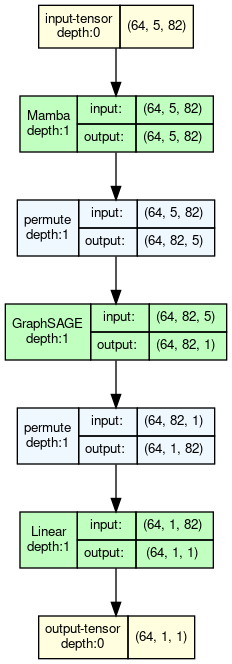

In [12]:
from torchview import draw_graph
import graphviz

graphviz.set_jupyter_format("png")

Mode = "train"
DEBUG = "FALSE"  #'''True'
DATASET = "PEMSD8"  # PEMSD4 or PEMSD8
DEVICE = "cuda:0"
MODEL = "AGCRN"

# get configuration
config_file = "./{}_{}.conf".format(DATASET, MODEL)
# print('Read configuration file: %s' % (config_file))
config = configparser.ConfigParser()
config.read(config_file)

# parser
args = {
    "dataset": DATASET,
    "mode": Mode,
    "device": DEVICE,
    "debug": DEBUG,
    "model": MODEL,
    "cuda": True,
    "val_ratio": 0.15,
    "test_ratio": 0.15,
    "lag": window,
    "horizon": predict,
    "num_nodes": XX.shape[2],
    "tod": False,
    "normalizer": "std",
    "column_wise": False,
    "default_graph": True,
    "input_dim": 1,
    "output_dim": 1,
    "embed_dim": 10,
    "cheb_k": 3,  # GCN param
    "rnn_units": 128,
    "num_layers": 3,
    "loss_func": "mae",
    "seed": 1,
    "batch_size": 32,
    "epochs": 1100,
    "lr_init": 0.001,
    "lr_decay": True,
    "lr_decay_rate": 0.5,
    "lr_decay_step": [40, 70, 100],
    "early_stop": True,
    "early_stop_patience": 200,
    "grad_norm": False,
    "max_grad_norm": 5,
    "real_value": False,
    "mae_thresh": None,
    "mape_thresh": 0,
    "log_dir": "./",
    "log_step": 20,
    "plot": False,
    "teacher_forcing": False,
    "d_in": 32,
    "hid": 32,
}

model_args = ModelArgs(
    args.get("d_in"),
    args.get("num_layers"),
    args.get("num_nodes"),
    args.get("lag"),
    args.get("horizon"),
)
print("model_args: ", model_args)
# model = SAMBA_GATv2(model_args, args.get('hid'), 2)
model = SAMBA_GraphSAGE(
    model_args,
    args.get("hid"),
    args.get("lag"),
    args.get("horizon"),
    args.get("embed_dim"),
)

# 1 train epoch
model_graph = draw_graph(
    model,
    input_size=[
        (64, 5, 82),
    ],
    depth=1,
    expand_nested=True,
)
model_graph.resize_graph(scale=5.0)  # scale as per the view
# model_graph.visual_graph.render(format='svg')
model_graph.visual_graph

model_args:  ModelArgs(d_model=32, n_layer=3, vocab_size=82, seq_in=5, seq_out=1, d_state=128, expand=2, dt_rank=2, d_conv=3, pad_vocab_size_multiple=8, conv_bias=True, bias=False)


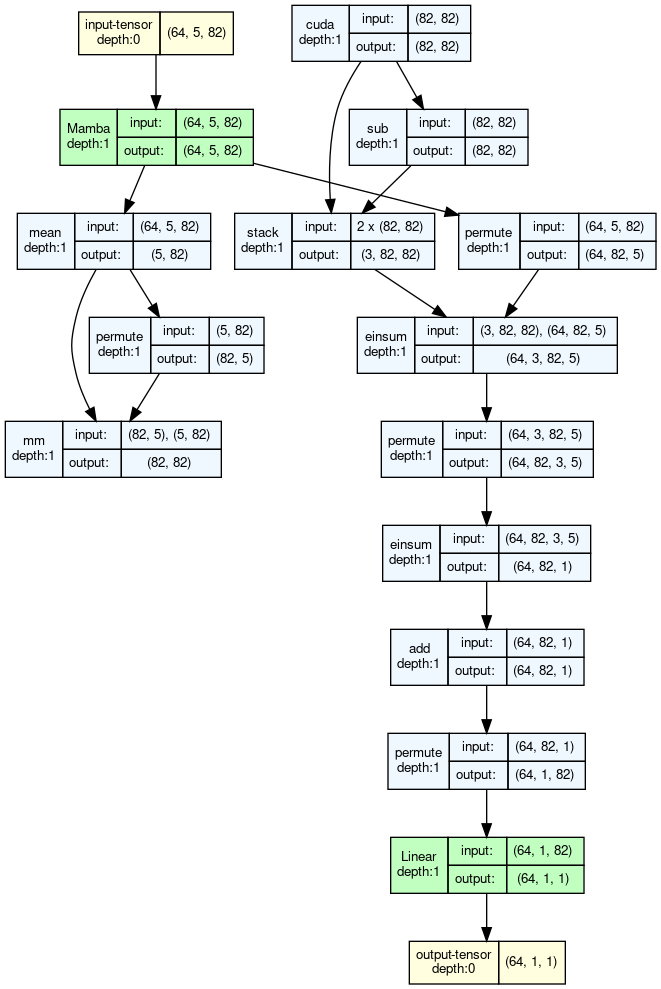

In [13]:
from torchview import draw_graph
import graphviz

graphviz.set_jupyter_format("png")

Mode = "train"
DEBUG = "FALSE"  #'''True'
DATASET = "PEMSD8"  # PEMSD4 or PEMSD8
DEVICE = "cuda:0"
MODEL = "AGCRN"

# get configuration
config_file = "./{}_{}.conf".format(DATASET, MODEL)
# print('Read configuration file: %s' % (config_file))
config = configparser.ConfigParser()
config.read(config_file)

# parser
args = {
    "dataset": DATASET,
    "mode": Mode,
    "device": DEVICE,
    "debug": DEBUG,
    "model": MODEL,
    "cuda": True,
    "val_ratio": 0.15,
    "test_ratio": 0.15,
    "lag": window,
    "horizon": predict,
    "num_nodes": XX.shape[2],
    "tod": False,
    "normalizer": "std",
    "column_wise": False,
    "default_graph": True,
    "input_dim": 1,
    "output_dim": 1,
    "embed_dim": 10,
    "cheb_k": 3,  # GCN param
    "gat_heads": 2,
    "rnn_units": 128,
    "num_layers": 3,
    "loss_func": "mae",
    "seed": 1,
    "batch_size": 32,
    "epochs": 1100,
    "lr_init": 0.001,
    "lr_decay": True,
    "lr_decay_rate": 0.5,
    "lr_decay_step": [40, 70, 100],
    "early_stop": True,
    "early_stop_patience": 200,
    "grad_norm": False,
    "max_grad_norm": 5,
    "real_value": False,
    "mae_thresh": None,
    "mape_thresh": 0,
    "log_dir": "./",
    "log_step": 20,
    "plot": False,
    "teacher_forcing": False,
    "d_in": 32,
    "hid": 32,
}

model_args = ModelArgs(
    args.get("d_in"),
    args.get("num_layers"),
    args.get("num_nodes"),
    args.get("lag"),
    args.get("horizon"),
)
print("model_args: ", model_args)
# init model
model = SAMBA(
    model_args,
    args.get("hid"),
    args.get("lag"),
    args.get("horizon"),
    args.get("embed_dim"),
    args.get("cheb_k"),
)
# model = Mamba(ModelArgs(args.get("d_in"),args.get("num_layers"),args.get("num_nodes"),args.get('lag'),args.get('horizon'))
#               ,args.get('hid'))

# 1 train epoch
model_graph = draw_graph(
    model,
    input_size=[
        (64, 5, 82),
    ],
    depth=1,
    expand_nested=True,
)
model_graph.resize_graph(scale=5.0)  # scale as per the view
# model_graph.visual_graph.render(format='svg')
model_graph.visual_graph